# Model-data calibration for the DVM-DOS-TEM model using [MADS](https://github.com/madsjulia/Mads.jl) julia

This example illustrates the usage of the MADS (Model Analysis & Decision Support) package. Here, we use MADS package for the data-model calibration, i.e., minimize the difference between observations and the corresponding modeled outputs. In this example, we wrap the DVM-DOS-TEM model with MADS to calibrate model parameters by comparing model outputs with observations from the Murphy Dome (black spruce) site near Fairbanks, Alaska. This example is for STEP1 only and assumes that a user has a background on six calibration steps and has all the required packages installed. Note that this example runs only from the docker container.

## STEP1-MD1 
In STEP1, we calibrate parameter `cmax` for four plant functional types (PFT) by tweaking `cmax` values in the `parameters/cmt_calparbgc.txt` file. Our target values are Gross Primary Productivity (GPP) values. The observed GPP values can be found in `calibration/calibration_targets.py`. 

In [12]:
# STEP1 (MD1)
# parameters: cmax
# targets: GPP[1:4], Nitrogen unlimited mode

import Mads
import PyCall
@show pwd()

pwd() = "/work/scripts"


"/work/scripts"

For **STEP1**, we setup the nitrogen unlimited mode. This mode can be enabled by setup the `calib_mode` eqaul to `'GPPAllIgnoringNitrogen'`. Below we embedded the python code inside the julia notebook. `PyCall` package provides the communication between `python` and `julia` languages. A similar simplified example that uses python from julia can be found on the MADS Github [page](https://github.com/madsjulia/Mads.jl/blob/master/notebooks/model_diagnostics_python/model_diagnostics_python.jl). Most of the utility functions required to run the calibration example live in `TEM.py`, which is located in `work/scripts` folder. The community number type (CMT) corresponding to black spruce forest is `cmtnum=1`. The code below uses two functions: `run_TEM` runs the model and grabs the outputs, and `get_targets` grabs the correspoding target values (in this case GPPs) from `calibration/calibration_targets.py` file. Typically vegetation carbon (above ground carbon) takes less time to equilibrate, which is why we use 100 years of pre-run and 200 of equilibrium run, which should suffice for the model to have a rich equilibrium state for vegetation. 

In [13]:
PyCall.py"""

import sys,os
sys.path.append(os.path.join('/work','scripts'))
import TEM

def run_TEM(x):
    
    # update param files
    for j in range(len(dvmdostem.params)):
        dvmdostem.params[j]['val']=x[j]   
    
    dvmdostem.clean()             # clean results from previous run
    dvmdostem.setup(calib=True)   # setup for a new run
    dvmdostem.update_params()     # save updated paramters into the cmt_calparbgc.txt
    dvmdostem.run()               # run the model

    return dvmdostem.get_calibration_outputs()[:4]

def get_targets():
    return dvmdostem.get_calibration_outputs(calib=True)[:4]

# istantiate the model
dvmdostem=TEM.TEM_model()
# set the path the input data  
dvmdostem.site='/data/input-catalog/cru-ts40_ar5_rcp85_mri-cgcm3_MurphyDome_10x10'
# set the path to the ouput folder
dvmdostem.work_dir='/data/workflows/MD1'
# set the mode
dvmdostem.calib_mode='GPPAllIgnoringNitrogen'
# set the run setup
dvmdostem.opt_run_setup='--pr-yrs 100 --eq-yrs 200 --sp-yrs 0 --tr-yrs 0 --sc-yrs 0'
# define parameters which will participate in calibration 
dvmdostem.set_params(cmtnum=1, params=['cmax','cmax','cmax','cmax'], \
                               pftnums=[0,1,2,3])
"""

Define the initial guess (IG) vector. Typically comes from the `cmt_calparbgc.txt`. These IG values need to be updated during the calibration process. 

In [14]:
#initial_guess=[385.0, 115.0, 201.0, 95.0]
initial_guess=[381.2, 113.9, 207.1, 93.3]
# the y_init line runs the run_TEM functions in the /data/workflows/MD1 folder
# y_init corresponds to the modeled GPP outputs
y_init=PyCall.py"run_TEM"(initial_guess)

NOTE: Make sure to enable 'eq' outputs in the config file!!!
[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_mri-cgcm3_MurphyDome_10x10 /data/workflows/MD1

[SA:setup] /work/scripts/runmask-util.py --reset --yx 0 0 /data/workflows/MD1/run-mask.nc

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/MD1/config/output_spec.csv --on GPP m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/MD1/config/output_spec.csv --on VEGC m p

[SA:setup] /work/scripts/outspec_utils.py --enable-cal-vars /data/workflows/MD1/config/output_spec.csv --on CMTNUM y

/data/workflows/MD1/config/output_spec.csv File present!
/data/workflows/MD1/config/config.js File present!
[SA:run] /work/dvmdostem --pr-yrs 100 --eq-yrs 200 --sp-yrs 0 --tr-yrs 0 --sc-yrs 0 -l fatal --force-cmt 1 --ctrl-file /data/workflows/MD1/config/config.js

Loading calibration_targets from : ['/work/calibration']
Resetting path...


4-element Vector{Float64}:
 306.14786250591277
  24.528357817977668
  47.22314184010029
  54.22532949447632

Let's grab the target GPP values and get their length. 

In [15]:
targets=PyCall.py"get_targets"()
obs_time=1:length(targets)
targets

Loading calibration_targets from : ['/work/calibration']
Resetting path...


4-element Vector{Float64}:
 468.74
  81.73
  27.51
  22.23

Ths function below serves as a broker between `MADS` julia and python's `run_TEM` function. 

In [16]:
function TEM_pycall(parameters::AbstractVector)
        predictions = PyCall.py"run_TEM"(parameters)
        return predictions
end

TEM_pycall (generic function with 1 method)

Below we set the calibration problem (`createproblem`) to minimize the difference between GPP observed and GPP modeled. `paramdist` sets up the range for the calibrated parameters (see `paramkey`). 

In [24]:
md = Mads.createproblem(
    initial_guess,               #IG vector to start the calibration
    targets,                     #obsevations
    TEM_pycall;                  #GPP modeled
    paramkey=["cmax0","cmax1","cmax2","cmax3"],
    #381.2, 113.9, 207.1, 93.3
    paramdist=["Uniform(370, 390)","Uniform(110, 120)","Uniform(200, 210)","Uniform(90, 100)"],
    obstime=obs_time,            #length of the observation vector
    obsweight=[100,100,100,100], #weight for target values
    problemname="STEP1-MD1")     

[ Info: Using the provided function in the Mads dictionary ...


Dict{Any, Any} with 4 entries:
  "Julia function" => TEM_pycall
  "Parameters"     => OrderedCollections.OrderedDict{Any, Any}("cmax0"=>Ordered…
  "Observations"   => OrderedCollections.OrderedDict{Any, Any}("o1"=>OrderedCol…
  "Filename"       => "STEP1-MD1.mads"

Dislpay parameter values and observations (targets). 

In [25]:
Mads.showparameters(md)
Mads.showobservations(md)

cmax0 =           381.2 distribution = Uniform(370, 390) 
cmax1 =           113.9 distribution = Uniform(110, 120) 
cmax2 =           207.1 distribution = Uniform(200, 210) 
cmax3 =            93.3 distribution = Uniform(90, 100) 
Number of optimizable parameters: 4
o1         target =          468.74 weight =             100 time =               1
o2         target =           81.73 weight =             100 time =               2
o3         target =           27.51 weight =             100 time =               3
o4         target =           22.23 weight =             100 time =               4
Number of observations is 4


Calibrate functions will run the calibration algorithm. In this case, by default, it is using [Levenberg-Marquardt Algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) to minimize the difference between modeled and observed GPPs. `tolOF` sets the tolerance number for the minimization function. `OF` stands for the root mean square difference between observations and modeled outputs.  `tolOFcount` sets the number of times after which it stops if there are no improvements in the `OF` number. This step could take a while to finish.   

In [ ]:
calib_param, calib_information = Mads.calibrate(md, tolOF=0.01, tolOFcount=4)

Save the plot of the match between observation and modeled outputs.

In [ ]:
Mads.plotmatches(md, calib_param, 
    xtitle="# of observations", ytitle="GPP",filename="STEP1-MD1-matchplot.png")

Display the match plots.

In [ ]:
Mads.display("STEP1-MD1-matchplot.png")

Quick sensitivity analysis will help better understand the dependencies between parameters and targets. If you run the calibration, you should have `calib_param` ready. If not, use the second line.

In [ ]:
localsa = Mads.localsa(md; filename="model_diagnostics.png", par=collect(values(calib_param)))

In [19]:
localsa = Mads.localsa(md; filename="model_diagnostics.png", par=initial_guess)

[ Info: Using the provided function in the Mads dictionary ...


NOTE: Make sure to enable 'eq' outputs in the config file!!!
NOTE: Make sure to enable 'eq' outputs in the config file!!!
NOTE: Make sure to enable 'eq' outputs in the config file!!!
NOTE: Make sure to enable 'eq' outputs in the config file!!!
NOTE: Make sure to enable 'eq' outputs in the config file!!!


[ Info: Using the provided function in the Mads dictionary ...


NOTE: Make sure to enable 'eq' outputs in the config file!!!
[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_mri-cgcm3_MurphyDome_10x10 /data/workflows/MD1

[SA:setup] /work/scripts/runmask-util.py --reset --yx 0 0 /data/workflows/MD1/run-mask.nc

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/MD1/config/output_spec.csv --on GPP m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/MD1/config/output_spec.csv --on VEGC m p

[SA:setup] /work/scripts/outspec_utils.py --enable-cal-vars /data/workflows/MD1/config/output_spec.csv --on CMTNUM y

/data/workflows/MD1/config/output_spec.csv File present!
/data/workflows/MD1/config/config.js File present!
[SA:run] /work/dvmdostem --pr-yrs 100 --eq-yrs 200 --sp-yrs 0 --tr-yrs 0 --sc-yrs 0 -l fatal --force-cmt 1 --ctrl-file /data/workflows/MD1/config/config.js

Loading calibration_targets from : ['/work/calibration']
Resetting path...
[SA:setup] /work/scripts/setup_wor

Dict{String, Any} with 6 entries:
  "of"          => 3.11205e8
  "jacobian"    => [1548.38 -28.5801 -36.5959 -194.019; -2.37471 335.659 -1.719…
  "covar"       => [4.91873e-7 2.0992e-7 5.45541e-7 4.59184e-7; 2.0992e-7 8.898…
  "eigenmatrix" => [-0.989567 -0.138194 -0.0218338 -0.0343803; 0.0190314 0.0390…
  "eigenvalues" => [4.09402e-7, 3.45448e-6, 8.86439e-6, 1.75722e-5]
  "stddev"      => [0.000701337, 0.00298296, 0.00417768, 0.00185945]

In [20]:
[Mads.getparamlabels(md) localsa["stddev"]]

4×2 Matrix{Any}:
 "cmax0"  0.000701337
 "cmax1"  0.00298296
 "cmax2"  0.00417768
 "cmax3"  0.00185945

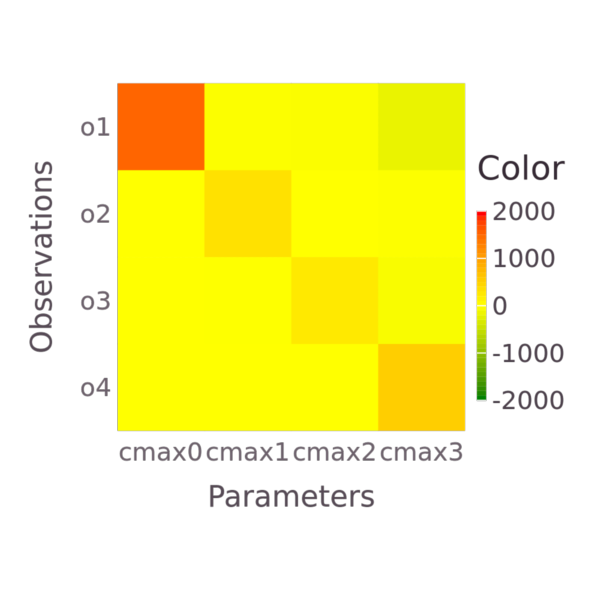

In [21]:
Mads.display("model_diagnostics-jacobian.png")

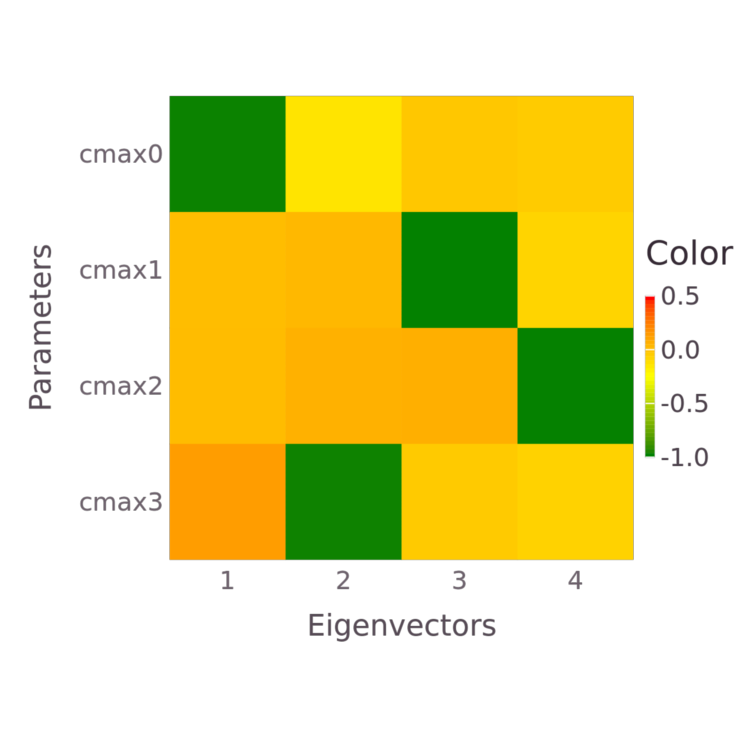

In [22]:
Mads.display("model_diagnostics-eigenmatrix.png")

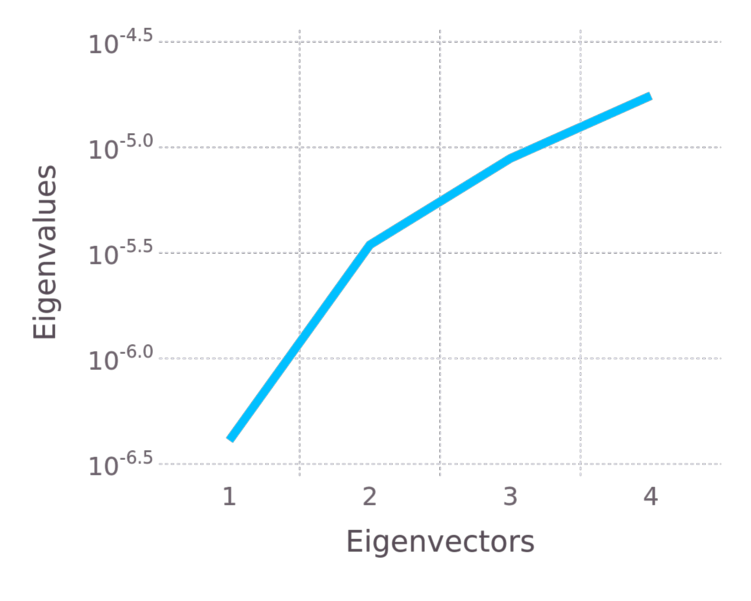

In [23]:
Mads.display("model_diagnostics-eigenvalues.png")